
🖼 frame_0000.jpg
GT Boxes: 60, Detected: 61
Accuracy: 100.00%, Mean IoU: 0.437


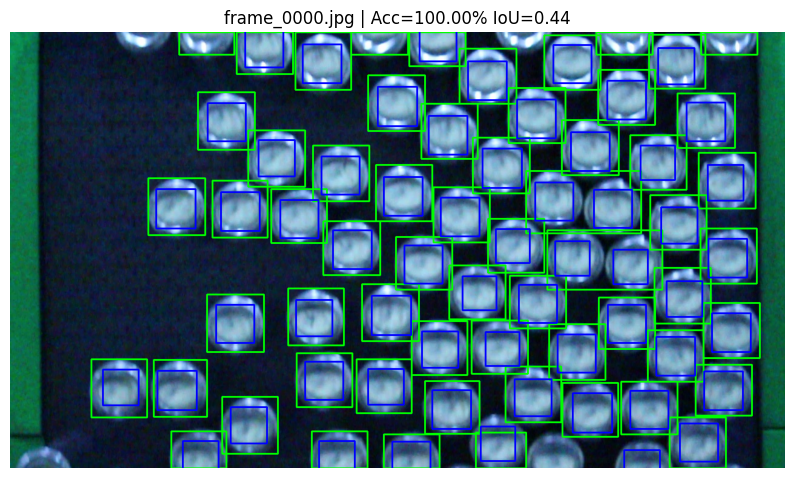


🖼 frame_0001.jpg
GT Boxes: 55, Detected: 59
Accuracy: 100.00%, Mean IoU: 0.437


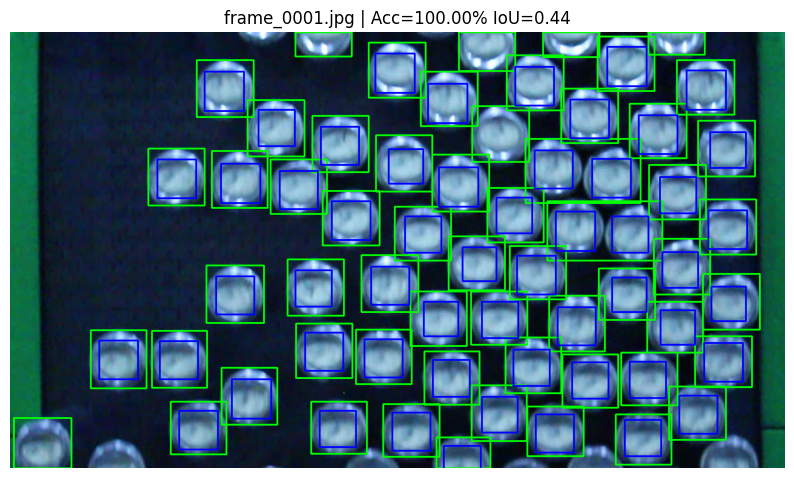


🖼 frame_0002.jpg
GT Boxes: 59, Detected: 60
Accuracy: 100.00%, Mean IoU: 0.436


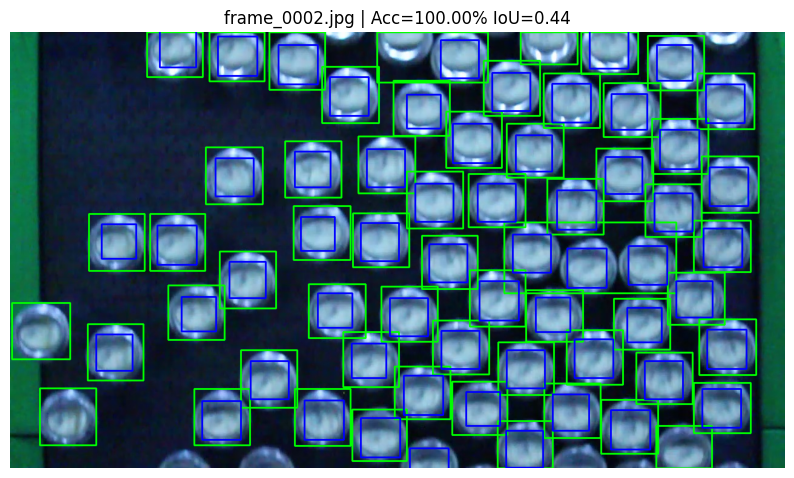


🖼 frame_0003.jpg
GT Boxes: 60, Detected: 57
Accuracy: 95.00%, Mean IoU: 0.427


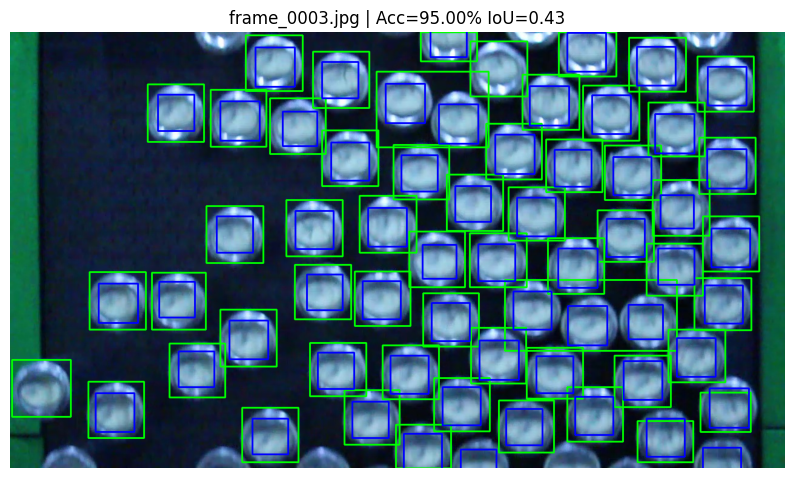


🖼 frame_0004.jpg
GT Boxes: 62, Detected: 64
Accuracy: 100.00%, Mean IoU: 0.444


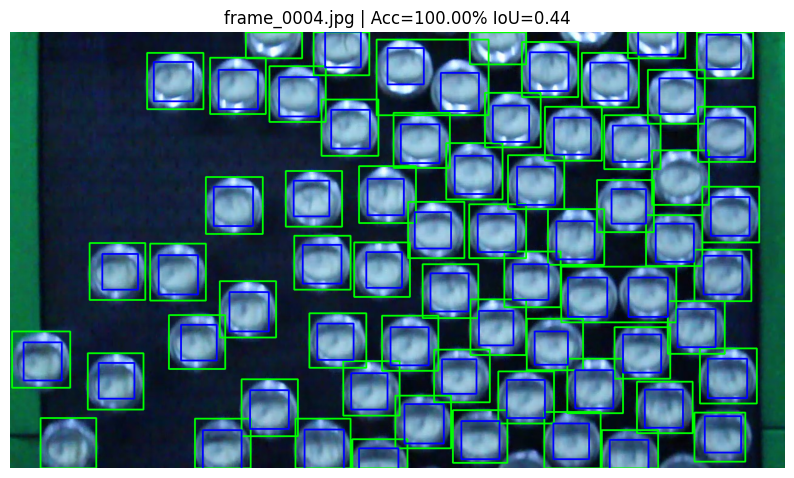


========== Overall Performance ==========
Average Accuracy : 99.00%
Average IoU       : 0.436


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# ==========================
# 1️⃣ Dataset Setup
# ==========================
image_paths = sorted(glob.glob("./frame_*.jpg"))
label_paths = sorted(glob.glob("./frame_*.txt"))


def load_yolo_labels_stretched(label_path, img_shape, orig_size, shift_x=0.25, shift_y=0.25, stretch_factor=1.25):
    """
    Load YOLO labels and convert normalized coordinates to pixel boxes,
    applying optional stretch (zoom-out) and shift.

    stretch_factor > 1.0  → zoom out (spread boxes outward)
    stretch_factor < 1.0  → zoom in (pull boxes toward center)
    """
    import os
    h_img, w_img = img_shape[:2]
    orig_w, orig_h = orig_size
    scale_x = w_img / orig_w
    scale_y = h_img / orig_h

    boxes = []
    if not os.path.exists(label_path):
        return boxes

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            _, x_c, y_c, w, h = map(float, parts[:5])

            # 🧭 stretch around center in normalized coordinate space
            # (0.5, 0.5) is image center in YOLO format
            x_c = 0.5 + (x_c - 0.5) * stretch_factor
            y_c = 0.5 + (y_c - 0.5) * stretch_factor

            # convert normalized → original pixels → current scale
            box_w = int(round(w * orig_w * scale_x))
            box_h = int(round(h * orig_h * scale_y))
            x_center = int(round(x_c * orig_w * scale_x))
            y_center = int(round(y_c * orig_h * scale_y))

            # manual pixel shift
            x_center += int(shift_x * w_img)
            y_center += int(shift_y * h_img)

            x = x_center - box_w // 2
            y = y_center - box_h // 2

            boxes.append((x, y, box_w, box_h))

    return boxes





def compute_iou(boxA, boxB):
    """Compute Intersection over Union between 2 boxes"""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

# ==========================
# 2️⃣ Process Each Frame
# ==========================
all_ious = []
all_accs = []

for img_path, label_path in zip(image_paths, label_paths):
    img = cv2.imread(img_path)
   # Assuming labels were made for 1920x1080 images
    orig_size = (1280, 720)
    
    # Slightly shift boxes toward bottom-right (e.g. 3% right, 2% down)
    gt_boxes = load_yolo_labels_stretched(label_path, img.shape, (1280, 720), stretch_factor=1.5)


    # === Preprocessing ===
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8), iterations=1)

    # === Detection ===
    mask_inv = cv2.bitwise_not(opening)
    contours_pred, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_boxes = []
    for cnt in contours_pred:
        if cv2.contourArea(cnt) > 2500:
            x, y, w, h = cv2.boundingRect(cnt)
            detected_boxes.append((x, y, w, h))

    # === Evaluation ===
    ious = []
    for gt in gt_boxes:
        best_iou = 0
        for pred in detected_boxes:
            best_iou = max(best_iou, compute_iou(gt, pred))
        ious.append(best_iou)
    mean_iou = np.mean(ious) if ious else 0
    accuracy = (min(len(detected_boxes), len(gt_boxes)) / len(gt_boxes)) * 100 if gt_boxes else 0

    all_ious.append(mean_iou)
    all_accs.append(accuracy)

    # === Display Per Frame (Optional) ===
    print(f"\n🖼 {os.path.basename(img_path)}")
    print(f"GT Boxes: {len(gt_boxes)}, Detected: {len(detected_boxes)}")
    print(f"Accuracy: {accuracy:.2f}%, Mean IoU: {mean_iou:.3f}")

    # Visualization
    output = img.copy()
    for (x, y, w, h) in detected_boxes:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for (x, y, w, h) in gt_boxes:
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.figure(figsize=(10, 7))
    plt.title(f"{os.path.basename(img_path)} | Acc={accuracy:.2f}% IoU={mean_iou:.2f}")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# ==========================
# 3️⃣ Final Summary
# ==========================
print("\n========== Overall Performance ==========")
print(f"Average Accuracy : {np.mean(all_accs):.2f}%")
print(f"Average IoU       : {np.mean(all_ious):.3f}")
print("=========================================")
